In [1]:
import tensorflow as tf
import pandas as pd

tf.compat.v1.disable_v2_behavior()

import codecs
import numpy as np
import csv
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn import preprocessing
import matplotlib.pyplot as plt
import tensorflow.keras.preprocessing
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Activation, BatchNormalization
# regularizers
from tensorflow.keras.layers import Conv1D, Conv2D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Dropout
from scipy import signal
import openpyxl
import seaborn as sns
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.layers import Dense, Input, Flatten, Add, concatenate, Dropout, Activation, Multiply
from tensorflow.keras.layers import LSTM, Bidirectional, GlobalMaxPooling1D, GlobalAveragePooling1D  
from tensorflow.keras.layers import Conv1D, AveragePooling1D, MaxPooling1D
from tensorflow.keras.utils import plot_model
from tensorflow.keras import activations
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
from math import *
import keras

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
df = pd.read_csv('solar_a.csv')
df = df.iloc[1:, :]
df.head()

,Date,Hour,Cloud coverage,Visibility,Temperature,Dew point,Relative humidity,Wind speed,Station pressure,Altimeter,Solar energy
1,2/1/2016,1,0.0,7.88,1.16,0.62,91.04,7.04,29.11,29.90,0.0
2,2/1/2016,2,0.0,9.84,1.22,0.96,89.28,8.96,29.12,29.91,0.0
3,2/1/2016,3,0.0,9.84,1.02,0.61,89.12,6.36,29.14,29.93,0.0
4,2/1/2016,4,0.0,9.88,0.83,0.45,90.08,6.12,29.15,29.94,0.0
5,2/1/2016,5,0.0,9.84,0.77,0.10,85.44,5.08,29.16,29.95,0.0


In [3]:
df['Time'] = pd.to_datetime(df['Date'])
df = df.drop(['Date'], axis=1)
df = df.set_index('Time')

In [4]:
for i in range(len(df)):
    position = df.index[i]
    #hour = position.hour
    day = position.day
    month = position.month
    df.loc[position, 'Month'] = month
    df.loc[position, 'Day'] = day

In [5]:
# df = df.drop(['Visibility', 'Altimeter'], axis=1)

In [6]:
X = df[df.columns.drop('Solar energy')].values
y = df['Solar energy'].values

y = y.reshape(-1, 1)

In [7]:
scaler_X = preprocessing.MinMaxScaler()
scaler_y = preprocessing.MinMaxScaler()

In [8]:
X_norm = scaler_X.fit_transform(X)
y_norm = scaler_y.fit_transform(y)

In [9]:
dataset_norm = np.concatenate((X_norm, y_norm), axis=1)

In [10]:
l = len(df)
train_end_idx = int(0.6*l)
cv_end_idx = int(0.9*l)

In [11]:
def create_dataset(dataset, timesteps, output_timesteps):
    dataX, dataY = [], []
    for i in range(len(dataset) - timesteps -output_timesteps - 1):
        a = dataset[i:(i + timesteps), :]
        dataX.append(a)
        dataY.append(dataset[(i + timesteps):(i+timesteps+output_timesteps), :])
    return np.array(dataX), np.array(dataY)

In [12]:
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1)) 

In [13]:
timesteps = 30
output_timesteps = 1

X, Y = create_dataset(dataset_norm, timesteps, output_timesteps)

X_train = X[:train_end_idx, :, :]
X_val = X[train_end_idx:cv_end_idx, :, :]
X_test = X[cv_end_idx:, :, :]

y_train = Y[:train_end_idx, :, -1]
y_val = Y[train_end_idx:cv_end_idx, :, -1]
y_test = Y[cv_end_idx:, :, -1]

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(9042, 30, 12)
(4521, 30, 12)
(1476, 30, 12)
(9042, 1)
(4521, 1)
(1476, 1)


In [14]:
y_test = y_test.reshape(-1, 1)
y_test_inv = scaler_y.inverse_transform(y_test)

In [15]:
# Define some common parameters

input_shape = X_train.shape[-2:]
loss = root_mean_squared_error
metric = ['mse', 'mae']
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
              lambda epoch: 1e-4 * 10**(epoch / 10))
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=100)

In [16]:
def plot_model_loss(history, name):
    
    # Evaluate train and validation accuracies and losses
    
    #train_rmse = history.history['root_mean_squared_error']
    #val_rmse = history.history['val_root_mean_squared_error']
    
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    # Visualize epochs vs. train and validation accuracies and losses
    
    # plt.figure(figsize=(20, 10))
    # plt.subplot(1, 2, 1)
    # plt.plot(train_rmse, label='Training RMSE')
    # plt.plot(val_rmse, label='Validation RMSE')
    # plt.legend()
    # plt.title('Epochs vs. Training and Validation RMSE')
    plt.figure(figsize=(20, 10))
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend()
    plt.title('Epochs vs. Training and Validation Loss', fontsize=24)
    plt.savefig(name, format='png')
    plt.show()

# **CNN-LSTM**

In [17]:
tf.keras.backend.clear_session()

multivariate_cnn_lstm = tf.keras.models.Sequential([
    Conv1D(filters=128, kernel_size=2,
           strides=1, padding='causal',
           activation='relu', 
           input_shape=input_shape),
    LSTM(128, recurrent_dropout=0.20, return_sequences=True),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.20),
    Dense(1)
])

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
                   'multivariate_cnn_lstm.h5', save_best_only=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, amsgrad=True)

multivariate_cnn_lstm.compile(loss=loss,
                          optimizer=optimizer,
                          metrics=metric)

multivariate_cnn_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 30, 128)           3200      
                                                                 
 lstm (LSTM)                 (None, 30, 128)           131584    
                                                                 
 flatten (Flatten)           (None, 3840)              0         
                                                                 
 dense (Dense)               (None, 128)               491648    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 626,561
Trainable params: 626,561
Non-trai

In [18]:
history = multivariate_cnn_lstm.fit(X_train, y_train, epochs=1000, batch_size=512,
                                validation_data=(X_val, y_val),
                                callbacks=[early_stopping,model_checkpoint])

Train on 9042 samples, validate on 4521 samples
Epoch 1/1000
9042/9042 [==============================] - ETA: 0s - loss: 0.3853 - mean_squared_error: 0.4405 - mean_absolute_error: 0.3853

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


9042/9042 [==============================] - 12s 1ms/sample - loss: 0.3853 - mean_squared_error: 0.4405 - mean_absolute_error: 0.3853 - val_loss: 0.1820 - val_mean_squared_error: 0.0948 - val_mean_absolute_error: 0.1820
Epoch 2/1000
9042/9042 [==============================] - 1s 125us/sample - loss: 0.1502 - mean_squared_error: 0.0596 - mean_absolute_error: 0.1502 - val_loss: 0.1294 - val_mean_squared_error: 0.0409 - val_mean_absolute_error: 0.1294
Epoch 3/1000
9042/9042 [==============================] - 1s 127us/sample - loss: 0.1161 - mean_squared_error: 0.0325 - mean_absolute_error: 0.1161 - val_loss: 0.0976 - val_mean_squared_error: 0.0262 - val_mean_absolute_error: 0.0976
Epoch 4/1000
9042/9042 [==============================] - 1s 127us/sample - loss: 0.0871 - mean_squared_error: 0.0267 - mean_absolute_error: 0.0871 - val_loss: 0.0805 - val_mean_squared_error: 0.0216 - val_mean_absolute_error: 0.0805
Epoch 5/1000
9042/9042 [==============================] - 1s 121us/sample - lo

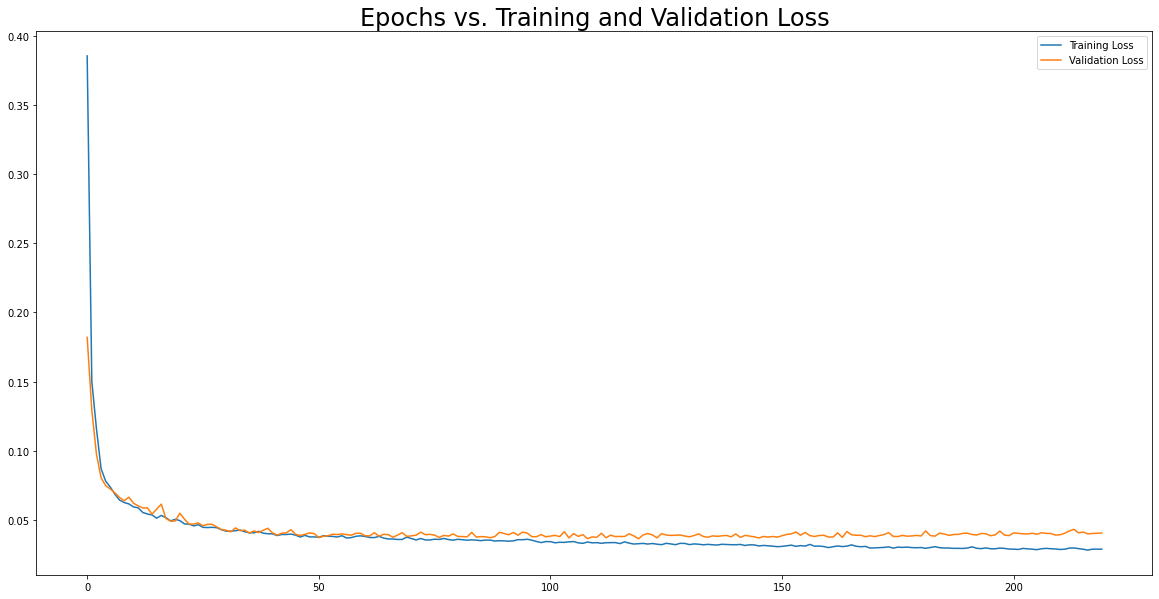

In [19]:
name = 'cnn_lstm.png'
plot_model_loss(history, name)

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


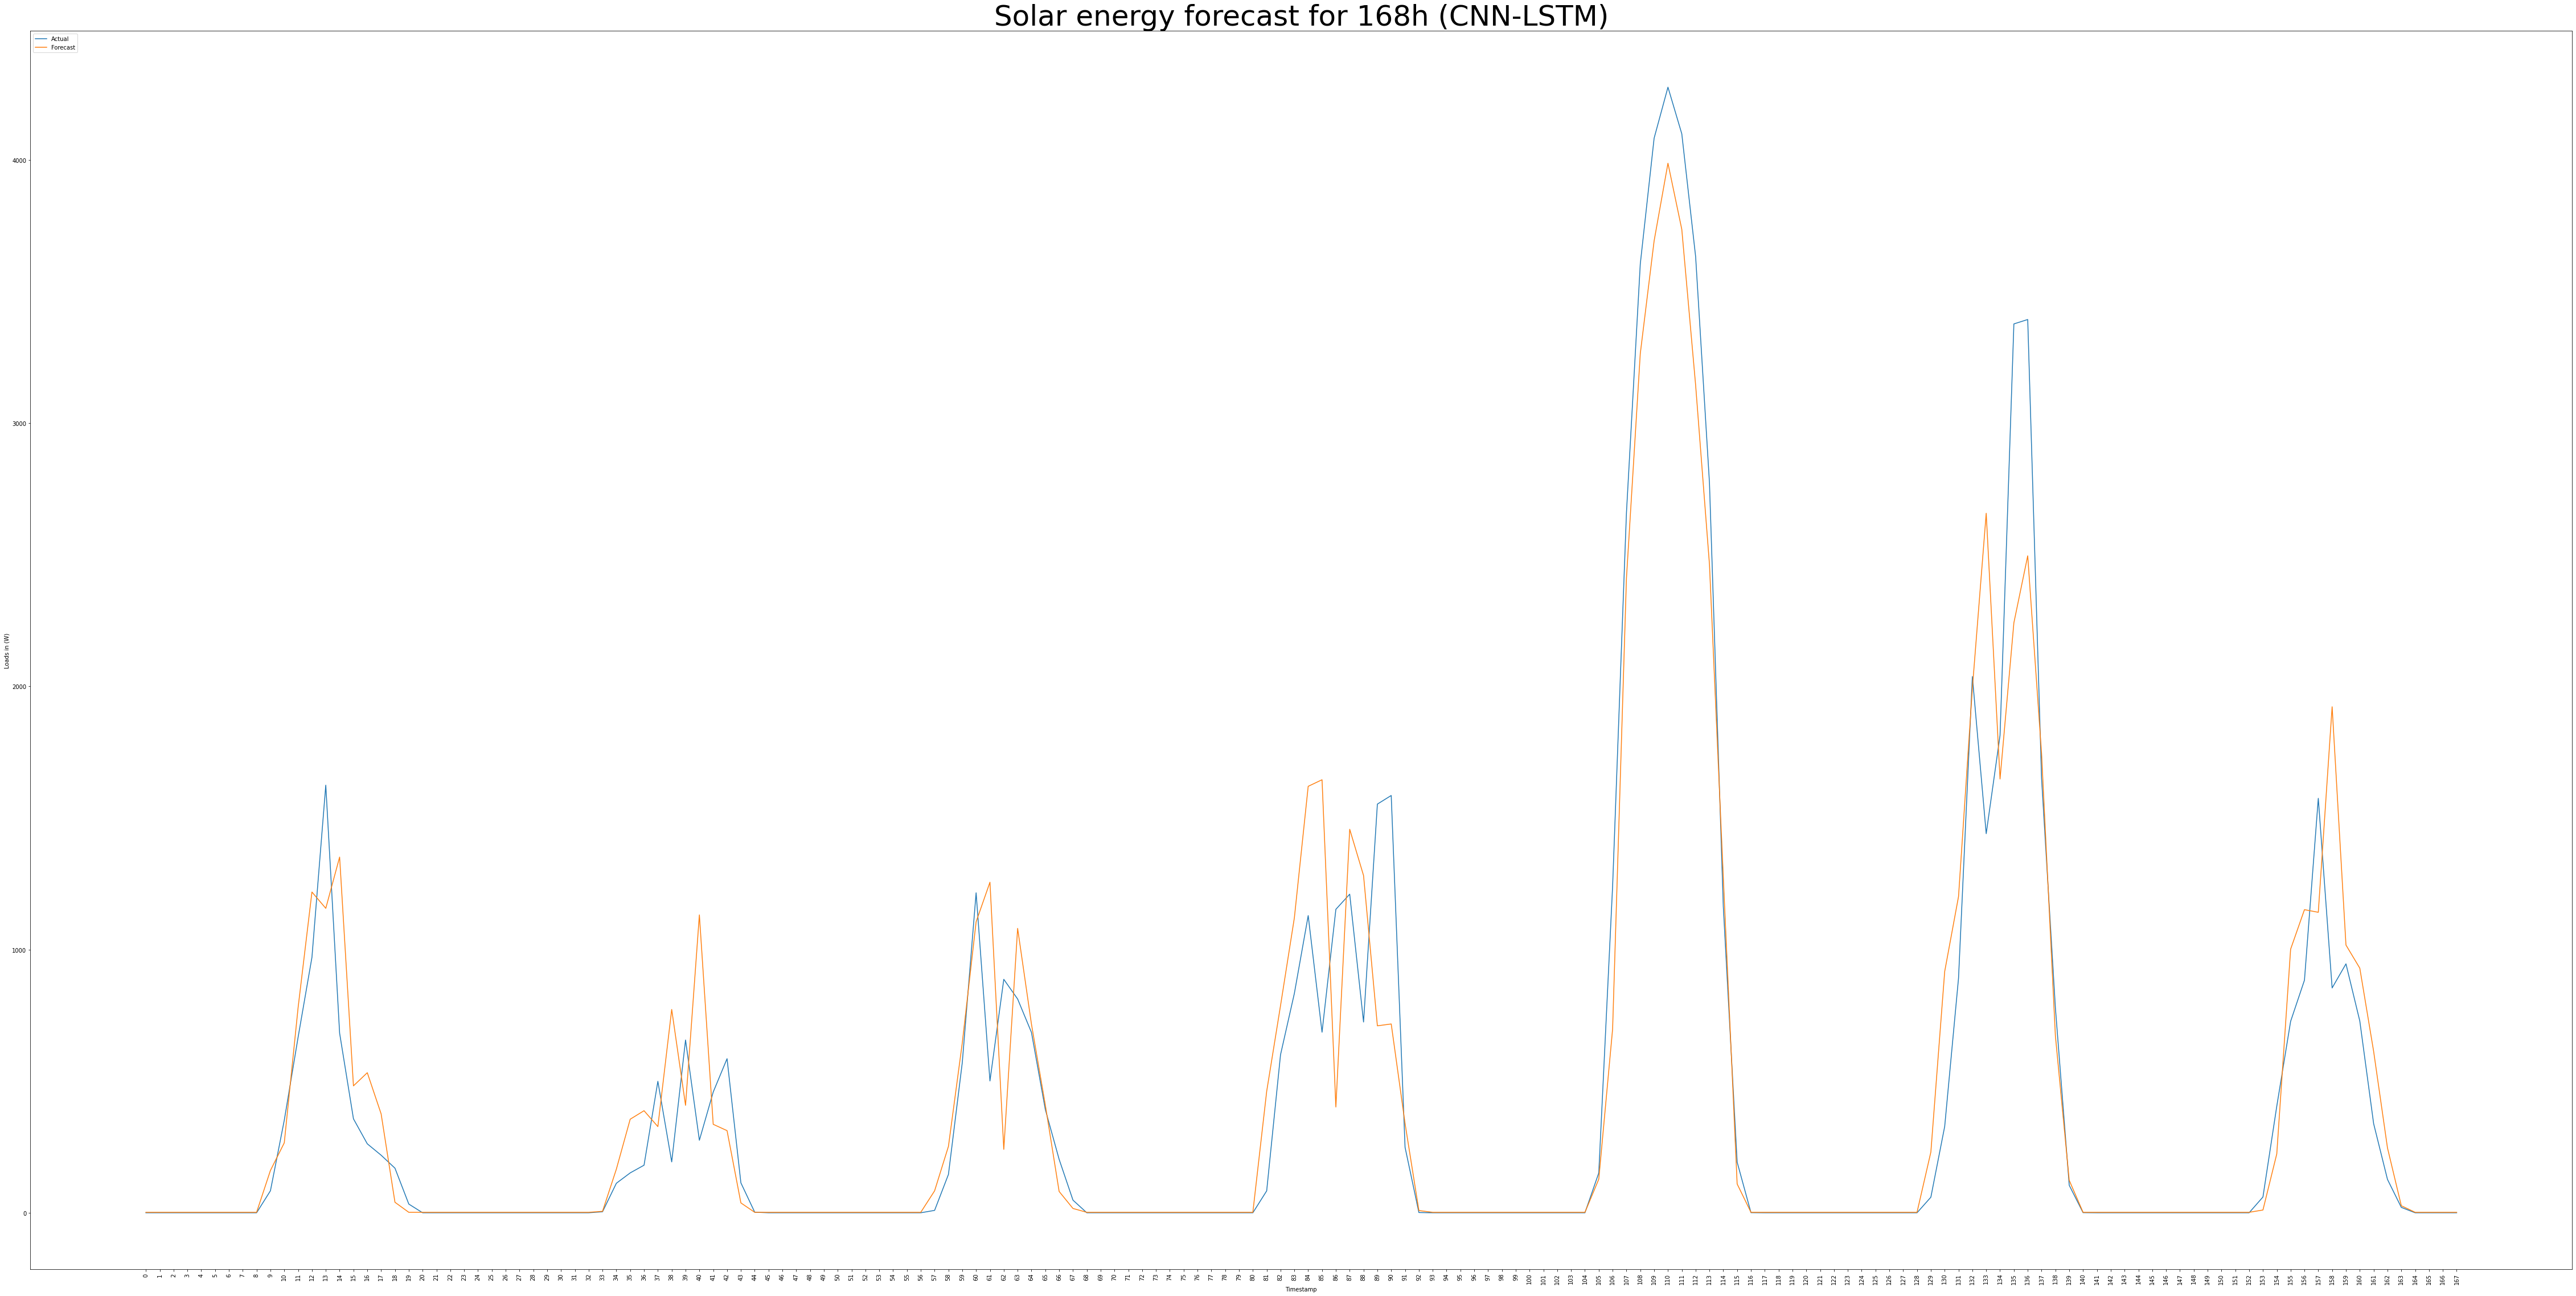

In [20]:
forecast = multivariate_cnn_lstm.predict(X_test[-168:])
cnn_lstm_forecast = scaler_y.inverse_transform(forecast)


x = []
for i in range(168):
  x.append(str(i))

plt.figure(figsize=(80, 40))
plt.plot(x,scaler_y.inverse_transform(y_test[-168:]), label="Actual")
plt.plot(x,cnn_lstm_forecast, label="Forecast")

plt.legend(loc="upper left")

plt.xticks(x)
plt.xlabel('Timestamp')
plt.ylabel('Loads in (W)')
plt.title('Solar energy forecast for 168h (CNN-LSTM)', fontsize=50)
plt.xticks(rotation = 90)
plt.savefig('cnn_lstm_forecast_actual.png', dpi=300)
plt.show()

In [21]:
multivariate_cnn_lstm = tf.keras.models.load_model('multivariate_cnn_lstm.h5',
              custom_objects={'root_mean_squared_error':root_mean_squared_error})

forecast = multivariate_cnn_lstm.predict(X_test)
cnn_lstm_forecast = scaler_y.inverse_transform(forecast)

rmse_lstm_n = sqrt(mean_squared_error(y_test,
                                    forecast))
print('RMSE (Normalized) of CNN-LSTM forecast: {}'
      .format(round(rmse_lstm_n, 8)))

rmse_lstm = sqrt(mean_squared_error(y_test_inv,
                                    cnn_lstm_forecast))
print('RMSE of CNN-LSTM forecast: {}'
      .format(round(rmse_lstm, 4)))

mae_lstm_n = mean_absolute_error(y_test,
                                    forecast)
print('MAE (Normalized) of CNN-LSTM forecast: {}'
      .format(round(mae_lstm_n, 8)))

mae_lstm = mean_absolute_error(y_test_inv,
                                    cnn_lstm_forecast)
print('MAE of CNN-LSTM forecast: {}'
      .format(round(mae_lstm, 4)))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


RMSE (Normalized) of CNN-LSTM forecast: 0.05703756
RMSE of CNN-LSTM forecast: 269.973
MAE (Normalized) of CNN-LSTM forecast: 0.02696232
MAE of CNN-LSTM forecast: 127.6194


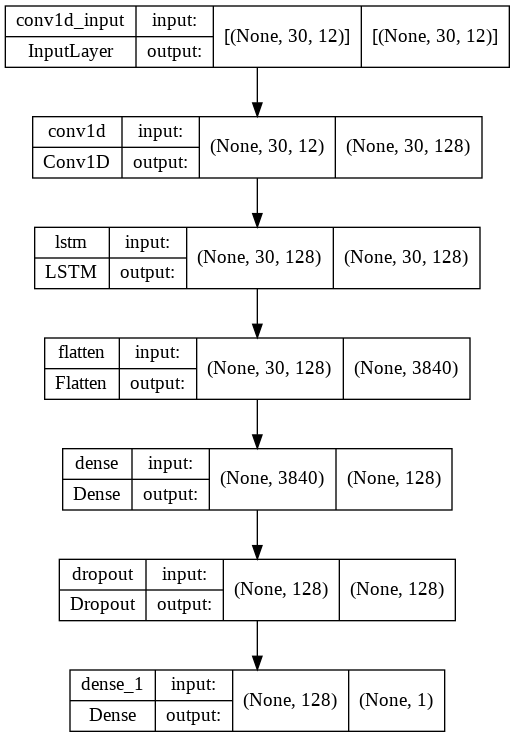

In [22]:
from keras.utils.vis_utils import plot_model
plot_model(multivariate_cnn_lstm, to_file='cnn_lstm_plot.png', show_shapes=True, show_layer_names=True)